In [1]:
from __future__ import print_function

from collections import Counter
import itertools as it

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics

In [2]:
df = pd.read_pickle("data/results/all_vs_all.pkl")
df.columns = [u'Tile A', u'Tile B', u'Precision', u'Recall', u'AUC']

from scipy.spatial import distance

POSITIONS = {
    'b220': (12, 8),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    'b396': ( 0, 0),
}

def get_dis(row):
    ta, tb = (row["Tile A"], row["Tile B"])
    pa, pb = map(float, POSITIONS[ta]), map(float, POSITIONS[tb])
    return distance.cityblock(pa, pb)

df["Distancia"] = df.apply(get_dis, axis=1)

In [3]:
all_tiles = list(set(list(df["Tile A"].values) + list(df["Tile B"].values)))
all_tiles

freq = dict(Counter(df["Tile A"].values).most_common())
for t in all_tiles:
    if t not in freq:
        freq[t] = (max(freq.values()) + 100) * -1

In [4]:
all_tiles = sorted(all_tiles, key=freq.get)
all_tiles

['b396',
 'b278',
 'b277',
 'b264',
 'b263',
 'b262',
 'b261',
 'b248',
 'b247',
 'b234',
 'b220']

In [5]:
def table(attr, use_distance=False):
    rows = []
    for ta in all_tiles:
        row = [ta]
        for tb in all_tiles:
            pa, pb = POSITIONS[ta], POSITIONS[tb]
            d = distance.cityblock(pa, pb) if use_distance else 1
            try:
                flt = (df["Tile A"] == ta) & (df["Tile B"] == tb)
                v = df[flt][attr].values[0] * d
            except:
                v = np.nan
            row.append(v)
        if len(set(row)) != 2:
            rows.append(row)
    tab = pd.DataFrame(rows, columns=["Tile A"] + all_tiles).set_index("Tile A")
    tab = tab.dropna(axis=1, how='all')
    return tab

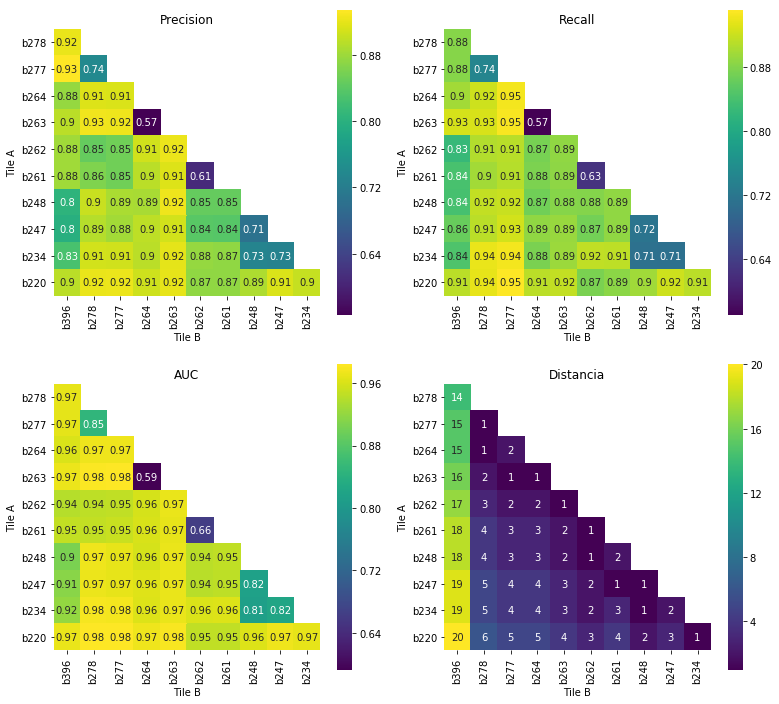

In [7]:
fig, axes = plt.subplots(2,2, figsize=(11, 10))

ax, name = axes[0][0], "Precision"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[0][1], "Recall"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][0], "AUC"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][1], "Distancia"
sns.heatmap(table(name), square=True, fmt=".2g", annot=True, ax=ax, cmap="viridis")
ax.set_title(name)
ax.set_xlabel("Tile B")


plt.tight_layout()
plt.savefig("plots/all_vs_all.pdf")

plt.show()

In [8]:
print(df.groupby("Distancia").median().to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
{} &  Precision &  Recall &   AUC \\
Distancia &            &         &       \\
\midrule
1.0       &      0.837 &   0.882 & 0.944 \\
2.0       &      0.889 &   0.888 & 0.962 \\
3.0       &      0.887 &   0.901 & 0.962 \\
4.0       &      0.897 &   0.908 & 0.967 \\
5.0       &      0.908 &   0.926 & 0.977 \\
6.0       &      0.923 &   0.938 & 0.984 \\
14.0      &      0.923 &   0.882 & 0.970 \\
15.0      &      0.905 &   0.891 & 0.965 \\
16.0      &      0.896 &   0.927 & 0.973 \\
17.0      &      0.882 &   0.826 & 0.940 \\
18.0      &      0.843 &   0.840 & 0.926 \\
19.0      &      0.813 &   0.854 & 0.918 \\
20.0      &      0.896 &   0.913 & 0.971 \\
\bottomrule
\end{tabular}



In [122]:
more = [("Precision", 'count')] + list(it.product(["Precision", "Recall", "AUC"]]))
print(more)

[('Precision', 'count'), ('Precision', '50%'), ('Precision', 'std'), ('Recall', '50%'), ('Recall', 'std'), ('AUC', '50%'), ('AUC', 'std')]


In [128]:
df.groupby("Distance").describe()[more]

Precision                        Recall                 AUC          
             count       50%       std       50%       std       50%       std
Distance                                                                      
1.0           11.0  0.836792  0.128258  0.881526  0.131564  0.944197  0.134723
2.0           11.0  0.888889  0.057832  0.887776  0.062160  0.962260  0.043619
3.0           10.0  0.886714  0.024365  0.900722  0.019362  0.961821  0.010783
4.0            8.0  0.896795  0.018828  0.907948  0.023369  0.966642  0.012595
5.0            4.0  0.907516  0.012449  0.925553  0.019788  0.976985  0.004990
6.0            1.0  0.922772       NaN  0.937626       NaN  0.984015       NaN
14.0           1.0  0.922513       NaN  0.881882       NaN  0.969681       NaN
15.0           2.0  0.905210  0.041171  0.890891  0.011325  0.964832  0.005123
16.0           1.0  0.895551       NaN  0.926927       NaN  0.972720       NaN
17.0           1.0  0.882353       NaN  0.825826       NaN  0.940103       NaN
18.0           2.0  0.842919  0.054459  0.840340  0.000708  0.926122  0.030098
19.0           2.0  0.812764  0.019624  0.853854  0.012741  0.917880  0.004744
20.0           1.0  0.895874       NaN  0.912913       NaN  0.971139       NaN

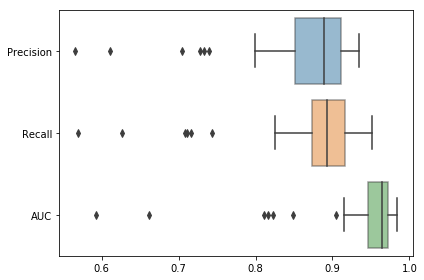

In [9]:
sns.boxplot(data=df["Precision Recall AUC".split()], orient="h", boxprops=dict(alpha=.5))
plt.tight_layout()
plt.savefig("plots/all_vs_all_boxplot.pdf")
plt.show()